In [191]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize

### Importing data 

In [4]:
s3 = boto3.resource('s3')

bucket = s3.Bucket('alpenglowoptics')

ll = list(bucket.objects.all())


In [5]:
fname_list = []
for l in ll:
    k = l.key
    if k.startswith('76AO/Strips/im') and not k.endswith('_max.tif'):
        fname_list.append(k)

In [6]:
af.download_s3('76AO/Strips/im_000005_000019.tif', '../data/im_000005_000019.tif')

In [7]:
af.download_s3('76AO/Strips/im_000006_000019.tif', '../data/im_000006_000019.tif')

In [104]:
af.download_s3('76AO/Strips/im_000007_000019.tif', '../data/im_000007_000019.tif')

In [9]:
im_5_19 = tiff.imread("../data/im_000005_000019.tif")

In [10]:
im_6_19 = tiff.imread("../data/im_000006_000019.tif")

In [105]:
im_7_19 = tiff.imread("../data/im_000007_000019.tif")

In [11]:
im_5_19.shape
#good shape

(900, 23872)

### Visual inspection 

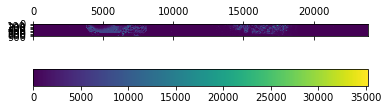

In [33]:
figure,axis = plt.subplots(1)
im_5 = axis.matshow(im_5_19)
figure.colorbar(im_5, orientation="horizontal")


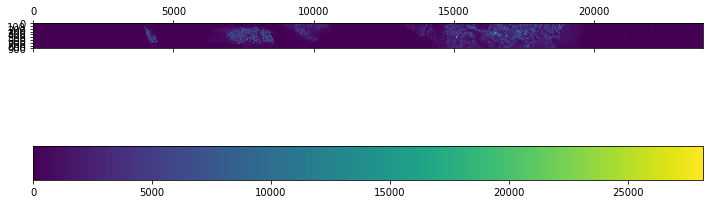

In [30]:
figure,axis = plt.subplots(1)
im_6 = axis.matshow(im_6_19)
plt.colorbar(im_6, orientation="horizontal")
figure.set_size_inches([12,12])

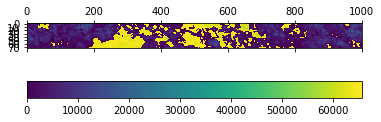

In [29]:
figure,axis = plt.subplots(1)
im = axis.matshow(im_5_19[:75,17000:18000] - im_6_19[825:,17000:18000])
plt.colorbar(im, orientation="horizontal")
#subtracting to see difference. Actually not a good idea because of strip-strip intensity difference

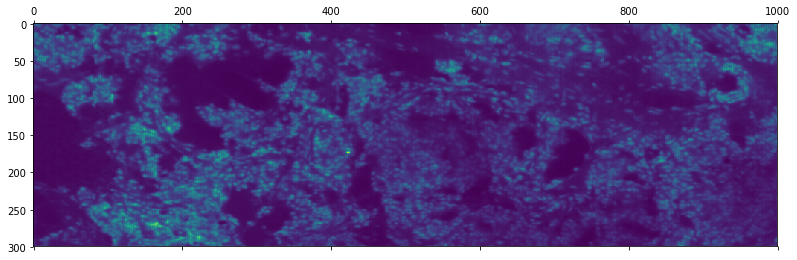

In [50]:
plt.matshow(im_5_19[:300,17000:18000])

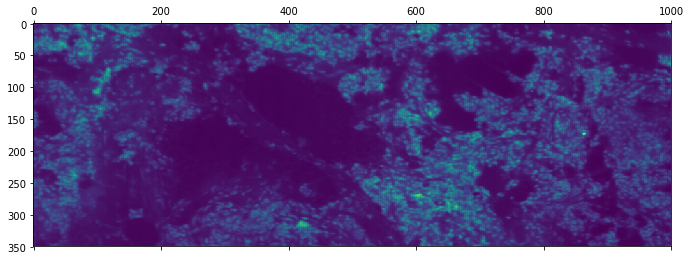

In [82]:
plt.matshow(im_5_19[:350,(17000-440):(18000-440)])

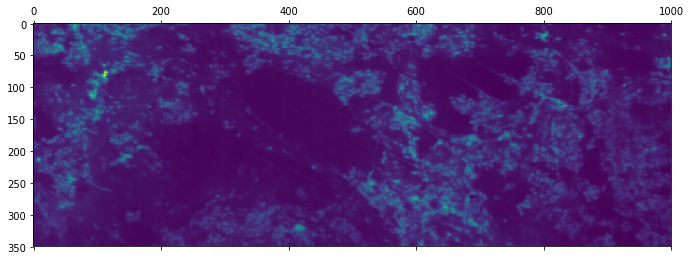

In [57]:
plt.matshow(im_6_19[550:,17000:18000])

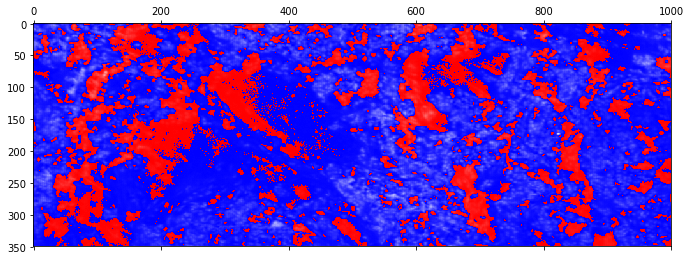

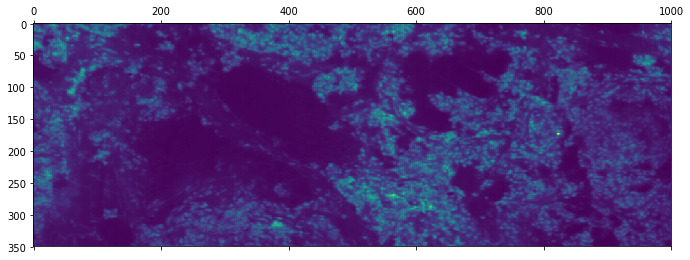

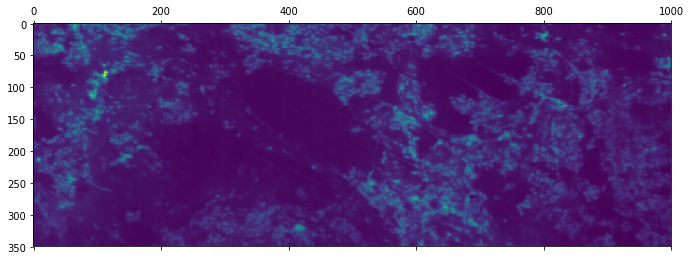

In [110]:
def jigger(x,y,stripOne, stripTwo):
    plt.matshow(stripOne[:x,(17000-y):(18000-y)] - stripTwo[900-x:,17000:18000], cmap='bwr')
    plt.matshow(stripOne[:x,(17000-y):(18000-y)])
    plt.matshow(stripTwo[900- x:,17000:18000])
jigger(350, 400, im_5_19, im_6_19)

### Looking for the sweet spot 

In [83]:
empty_set=np.zeros([201,201]) #first create an empty set of the correct size
xs = np.linspace(100,700,201).astype(int) #take 201 numbers from 100 to 700
ys = np.linspace(100,700,201).astype(int) #need to say its an integer
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_5_19[:x,(17000-y):(18000-y)]), np.ravel(im_6_19[900-x:,17000:18000]))[0,1]
        
    

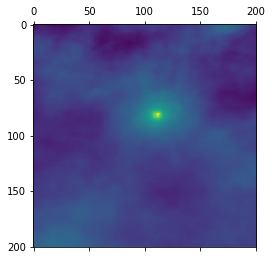

In [84]:
plt.matshow(empty_set)

In [85]:
np.max(empty_set) #max correlation coefficient for empty_set

0.87488192740191084

In [86]:
np.where(empty_set == np.max(empty_set)) #what are the coordinates of the max?

(array([82]), array([111]))

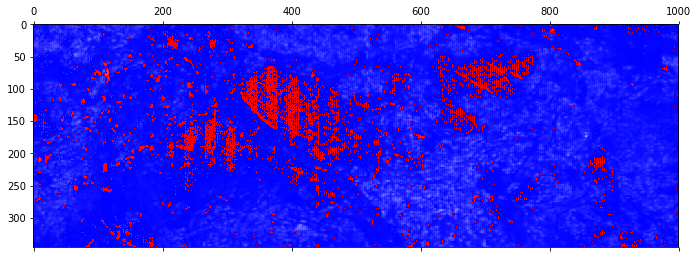

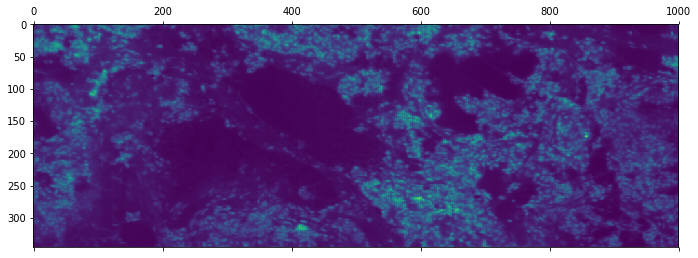

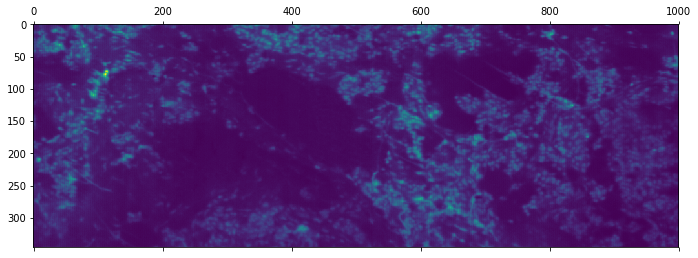

In [92]:
jigger(xs[82], ys[111], im_5_19, im_6_19) #show a plot of the diff between im_5 and im_6 at those coords

In [93]:
xs[82] #what is the actual value? How close is it to our guess of 350?

346

In [94]:
xs

array([100, 103, 106, 109, 112, 115, 118, 121, 124, 127, 130, 133, 136,
       139, 142, 145, 148, 151, 154, 157, 160, 163, 166, 169, 172, 175,
       178, 181, 184, 187, 190, 193, 196, 199, 202, 205, 208, 211, 214,
       217, 220, 223, 226, 229, 232, 235, 238, 241, 244, 247, 250, 253,
       256, 259, 262, 265, 268, 271, 274, 277, 280, 283, 286, 289, 292,
       295, 298, 301, 304, 307, 310, 313, 316, 319, 322, 325, 328, 331,
       334, 337, 340, 343, 346, 349, 352, 355, 358, 361, 364, 367, 370,
       373, 376, 379, 382, 385, 388, 391, 394, 397, 400, 403, 406, 409,
       412, 415, 418, 421, 424, 427, 430, 433, 436, 439, 442, 445, 448,
       451, 454, 457, 460, 463, 466, 469, 472, 475, 478, 481, 484, 487,
       490, 493, 496, 499, 502, 505, 508, 511, 514, 517, 520, 523, 526,
       529, 532, 535, 538, 541, 544, 547, 550, 553, 556, 559, 562, 565,
       568, 571, 574, 577, 580, 583, 586, 589, 592, 595, 598, 601, 604,
       607, 610, 613, 616, 619, 622, 625, 628, 631, 634, 637, 64

In [95]:
ys[111] # what is the actual value? how close is it to our guess of 440?

433

Now we need to use a smaller step size = 1 around the range near [346,433]

In [98]:
xs = np.arange(340,360,1).astype(int)
ys = np.arange(430,460,1).astype(int)
empty_set=np.zeros([xs.shape[0],ys.shape[0]])
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_5_19[:x,(17000-y):(18000-y)]), np.ravel(im_6_19[900-x:,17000:18000]))[0,1]
        

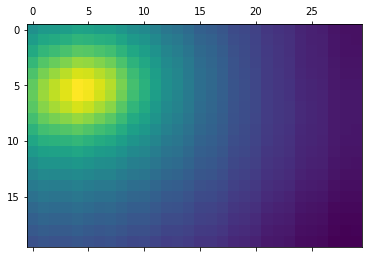

In [99]:
plt.matshow(empty_set)

In [100]:
np.where(empty_set == np.max(empty_set))

(array([5]), array([4]))

In [101]:
xs[5]

345

In [102]:
ys[4]

434

### Now we need to test with im_7

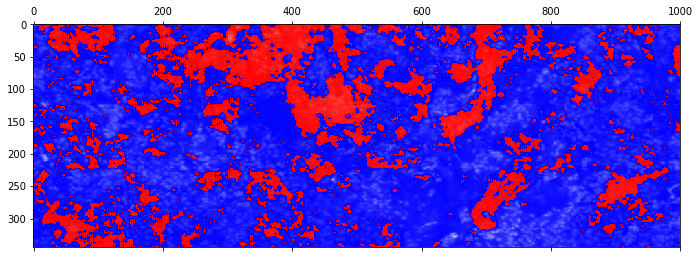

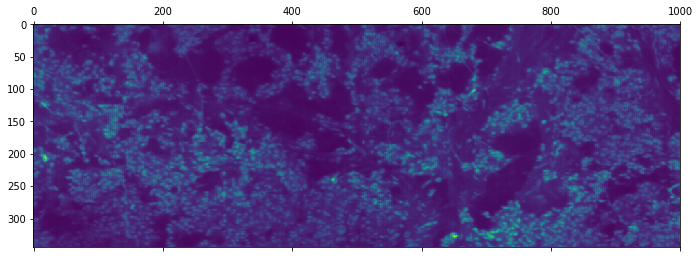

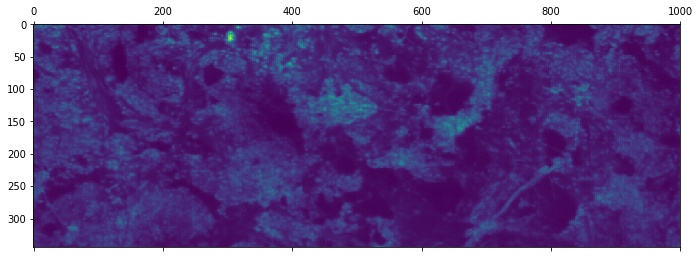

In [112]:
jigger(345, 434, im_6_19, im_7_19)

In [143]:
xs = np.array([345]) #take 201 numbers from 100 to 700
ys = np.linspace(-5000,5000,501).astype(int) #need to say its an integer
empty_set=np.zeros([xs.shape[0],ys.shape[0]]) #create a set of the correct size to contain correlations
for i in range(len(xs)):
    x = xs[i]
    for j in range(len(ys)):
        y = ys[j]
        empty_set[i,j] = np.corrcoef(np.ravel(im_6_19[:x,(10000-y):(15000-y)]), np.ravel(im_7_19[900-x:,10000:15000]))[0,1]
        
    

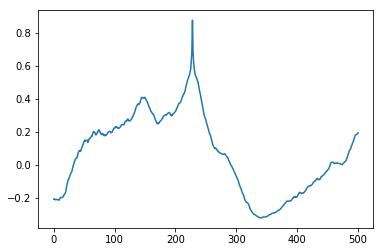

In [144]:
plt.plot(empty_set.T)

In [145]:
np.where(empty_set == np.nanmax(empty_set))

(array([0]), array([228]))

In [146]:
np.nanmax(empty_set)

0.87448393442098782

In [147]:
ys[228]

-440

### Method 2: The minimization function

In [173]:
def diff_squared(image1, image2):
    rmse = np.sqrt(np.mean((image1 - image2)**2))
    return rmse

In [193]:
def err_func(params, image1, image2):
    x, y = params
    x = int(x*image1.shape[0])
    y = int(y*image1.shape[1])
    if y>0:
        a = image1[:x,:image1.shape[1]-y]
        b = image2[image2.shape[0]-x:,y:]
    else:
        a = image1[:x,-y:]
        b = image2[image2.shape[0]-x:,:image2.shape[1]+y]
    rmse = np.sqrt(np.mean((a - b)**2))
    return rmse
err_func([345,-120], im_6_19, im_7_19)

129.19427126830217

In [187]:
def test(image1, image2, x, y):
    if y>0:
        a = image1[:x,:image1.shape[1]-y]
        b = image2[image2.shape[0]-x:,y:]
    else:
        a = image1[:x,-y:]
        b = image2[image2.shape[0]-x:,:image2.shape[1]+y]
    return a, b
a, b = test(im_6_19, im_7_19, 345, -120)
a.shape, b.shape

((345, 23752), (345, 23752))

In [ ]:
optimize.minimize(err_func, [0.3,0.0], args=(im_6_19, im_7_19))

### Next step: stitching after we know offsets 

In [152]:
offset = transform.SimilarityTransform(translation=(345, -440))
no_offset = transform.SimilarityTransform(translation=(0, 0))

In [169]:
im_7_transformed = transform.warp(im_7_19, inverse_map=no_offset, output_shape=((2*im_7_19.shape[0]-345), (2*im_7_19.shape[1]-im_7_19.shape[1]-440)))
im_6_transformed = transform.warp(im_6_19, inverse_map=offset, output_shape=((2*im_6_19.shape[0]-345), (2*im_6_19.shape[1]-im_6_19.shape[1]-440)))

In [168]:
im_7_transformed.shape

(1455, 23432)

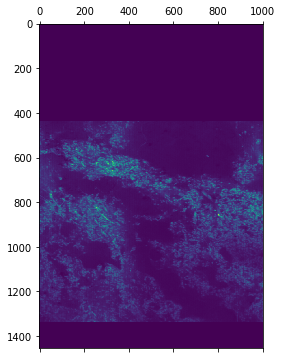

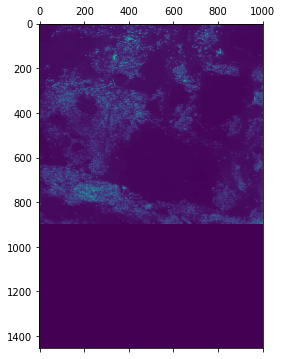

In [170]:
plt.matshow(im_6_transformed[:,15000:16000])
plt.matshow(im_7_transformed[:,15000:16000])

In [171]:
mask = (im_7_transformed != 0) & (im_6_transformed != 0)
registered = im_7_transformed + im_6_transformed
registered[mask] /= 2

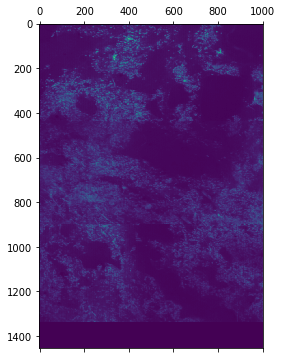

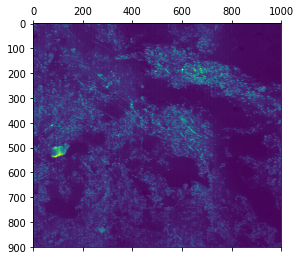

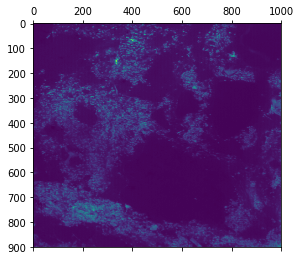

In [172]:
plt.matshow(registered[:,15000:16000])
plt.matshow(im_6_19[:,15000:16000])
plt.matshow(im_7_19[:,15000:16000])